<a href="https://colab.research.google.com/github/33quitykubby/Rabbit_DNN_1_2/blob/main/Rabbit_CNN_1_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN

サンプルコード2_6_simple_convolution_network_after.ipynb  
写経  

# 日本時間にする

In [22]:
  !rm /etc/localtime
  !ln -s /usr/share/zoneinfo/Asia/Tokyo /etc/localtime
  !date

Thu Apr 29 21:50:11 JST 2021


# ライブラリのインポート

In [23]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import os
import glob

import librosa

import datetime

import gc

from sklearn.datasets import load_boston
from pandas import DataFrame

In [24]:
#開始時刻
start_time = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
print("start_time=",start_time)

start_time= 2021-04-29 21:50:11.949972+09:00


# 乱数シードの初期化






In [25]:
import os 
import numpy as np
from sklearn import model_selection
import tensorflow as tf
import random

COMMON_SEED = 0
STANDARD_SEED = 0
NP_SEED = 0
TF_SEED = 0 

# np.random.seed(STANDARD_SEED)
# random.seed(NP_SEED)
# tf.random.set_seed(TF_SEED)

def seed_everything():
    random.seed(STANDARD_SEED)
    os.environ['PYTHONHASHSEED'] = str(COMMON_SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    np.random.seed(NP_SEED)
    tf.random.set_seed(TF_SEED)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)


In [26]:
#乱数シード固定

seed_everything()

# マウント

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 共通クラス

## class Relu

In [28]:
class Relu:
  def __init__(self):
    self.mask = None
  
  def forward(self, x):
    self.mask = ( x <= 0 )
    out = x.copy()
    # Trueの箇所を0にする
    out[self.mask] = 0
  
    return out

  def backward(self, dout):
    self.mask = ( dout > 0)
    out = dout.copy()
    # Trueの箇所を0にする
    dout[self.mask] = 0
    dx = dout

    return dx
  



## class Affine（全結合層）

$$dout = x・W + b$$

In [29]:
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b

    self.x = None
    self.original_x_shape = None
    
    #重み、バイアスの微分
    self.dW = None
    self.db = None
  
  def forward(self, x):
    #　テンソル対応
    self.original_x_shape = x.shape
    # print("x.org.shape=",self.original_x_shape)
    x = x.reshape(x.shape[0], -1)
    self.x = x
    # print("x.shape=",self.x.shape)

    out = np.dot(self.x, self.W) + self.b

    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout,axis=0)

    # 入力データの形状にもどしてあげる
    dx = dx.reshape(*self.original_x_shape)
    return dx


## class SoftmaxWithLoss

In [30]:
class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.d = None

  def softmax(self, x):
    if x.ndim == 2:
      x = x.T
      x = x - np.max(x, axis=0)
      y = np.exp(x) / np.sum(np.exp(x), axis=0)
      return y.T

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

  def cross_entropy_error(self, d, y):
    if y.ndim == 1:
      d = d.reshape(1, d.size)
      y = y.reshape(1, y.size)

    #教師データがone-hotの場合、正解ラベルのインデックスに変換
    if d.size == y.size:
      d = d.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), d] + 1e-7)) / batch_size

  def forward(self, x, d):
    self.d = d
    self.y = self.softmax(x)
    self.loss = self.cross_entropy_error(self.d, self.y)

    return self.loss

  def backward(self, dout=1):
    batch_size = self.d.shape[0]
    if self.d.size == self.y.size: # 教師データがone-hotの場合
      dx = (self.y - self.d) / batch_size
    else:
      dx = self.y.copy()
      dx[np.arange(batch_size), self.d] -= 1
      dx = dx / batch_size

    return dx

## class Dropout

In [31]:
class Dropout:
  def __init__(self, dropout_ratio=0.5):
    self.dropout_ratio = dropout_ratio
    self.mask = None

  def forward(self, x, train_flg = True):
    if train_flg:
      self.mask = np.random.rand(*x.shape) > self.dropout_ratio
      return x * self.mask
    else:
      return x * (1.0 - self.dropout_ratio)

  def backward(self, dout):
    return dout * self.mask

## class Adam

In [32]:
class Adam:
  def __init__(self, learning_rate = 0.001, beta1 = 0.9, beta2 = 0.999):
    self.learning_rate = learning_rate
    self.beta1 = beta1
    self.beta2 = beta2
    self.iter = 0
    self.m = None
    self.v = None

  def update(self, params, grad):
    if self.m is None:
      self.m , self.v = {}, {}
      for key, val in params.items():
        self.m[key] = np.zeros_like(val)
        self.v[key] = np.zeros_like(val)

    self.iter += 1
    lr_t = self.learning_rate * np.sqrt(1.0 - self.beta2 ** self.iter) / (1.0 - self.beta1 ** self.iter)

    for key in params.keys():
      self.m[key] += (1 - self.beta1) * ( grad[key] - self.m[key])
      self.v[key] += (1 - self.beta2) * ( grad[key] ** 2 - self.v[key])

      params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key])+1e-7)

# 共通関数

## image to column

  

In [33]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
  # N : number
  # C : channel
  # H : height
  # W : width
  N, C, H, W = input_data.shape
  out_h = ( (H + 2*pad - filter_h) // stride ) + 1 
  out_w = ( (W + 2*pad - filter_w) // stride ) + 1 

  # print("out_h={}, out_w={}".format(out_h, out_w))

  img = np.pad( input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
  col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

  for y in range(filter_h):
    y_max = y + stride * out_h
    # print("y_max=",y_max)
    for x in range(filter_w):
      x_max = x + stride * out_w
      # print("x_max=",x_max)
      col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
        # print("---------------------\n", col[:, :, y, x, :, :])
      # print("---------------------\n",img[:, :, y:y_max:stride, x:x_max:stride])
      # print("---------------------\n",img[:, :, y:y_max, x:x_max])
      # print("---------------------")

  col = col.transpose(0, 4, 5, 1, 2, 3) # (N, C, filter_h, filter_w, out_h, out_w) - > (N, filter_w, out_h, out_w, C, filter_h)
  # print("---------------------\n", col)
      
  col = col.reshape(N * out_h * out_w, -1)

  return col


In [34]:
#　テスト 
input_data = np.random.rand(2, 1, 4, 4)*100//1 # Number, Channel Height, Width
print("==============================================\n",input_data)
print("==============================================")
filter_h = 3
filter_w = 3
stride = 1
pad = 0
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print("=============================================\n",col)
print("=============================================")

 [[[[54. 71. 60. 54.]
   [42. 64. 43. 89.]
   [96. 38. 79. 52.]
   [56. 92.  7.  8.]]]


 [[[ 2. 83. 77. 87.]
   [97. 79. 46. 78.]
   [11. 63. 14. 94.]
   [52. 41. 26. 77.]]]]
 [[54. 71. 60. 42. 64. 43. 96. 38. 79.]
 [71. 60. 54. 64. 43. 89. 38. 79. 52.]
 [42. 64. 43. 96. 38. 79. 56. 92.  7.]
 [64. 43. 89. 38. 79. 52. 92.  7.  8.]
 [ 2. 83. 77. 97. 79. 46. 11. 63. 14.]
 [83. 77. 87. 79. 46. 78. 63. 14. 94.]
 [97. 79. 46. 11. 63. 14. 52. 41. 26.]
 [79. 46. 78. 63. 14. 94. 41. 26. 77.]]


## columun to image

  

In [35]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
  # N : number
  # C : channel
  # H : height
  # W : width
  N, C, H, W = input_shape
  # print("N={}, C={}, H={}, W={}".format(N,C,H,W))
  out_h = ( (H + 2*pad - filter_h) // stride ) + 1 
  out_w = ( (W + 2*pad - filter_w) // stride ) + 1 

  # print("out_h={}, out_w={}".format(out_h, out_w))

  col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0,3,4,5,1,2).astype(int)

  img = np.zeros((N, C, H + 2 * pad + stride -1, W + 2 * pad + stride -1)).astype(int)

  for y in range(filter_h):
    y_max = y + stride * out_h
    for x in range(filter_w):
      x_max = x + stride * out_w
      img[:, :, y:y_max:stride, x:x_max:stride] |= col[:,:,y,x,:,:]
      # print("---------------------\n", col[:, :, y, x, :, :])
      # print("---------------------\n",img[:, :, y:y_max:stride, x:x_max:stride])
      # print("---------------------\n",img)
      # print("---------------------")

  return img[:, :, pad:H + pad, pad:W + pad]


In [36]:
#　テスト 
N_DATAS = 2
CHANNEL = 1
HEIGHT = 4
WIDTH = 4
input_data = np.random.rand(N_DATAS, CHANNEL, HEIGHT, WIDTH)*100//1 # Number, Channel Height, Width
print("==============================================\n",input_data)
print("==============================================")
filter_h = 3
filter_w = 3
stride = 1
pad = 0
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print("=============================================\n",col)
print("=============================================")
img = col2im(col, input_data.shape, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print("********************************************\n",img)
print("********************************************")

if np.all(img == input_data):
  print("img is same as input_data")
else:
  print("WOOOOOOOOOO not same img vs input_data")

 [[[[45. 56.  1. 61.]
   [61. 61. 94. 68.]
   [35. 43. 69.  6.]
   [66. 67. 21. 12.]]]


 [[[31. 36. 57. 43.]
   [98. 10. 20. 16.]
   [65. 25. 46. 24.]
   [15. 11. 65. 13.]]]]
 [[45. 56.  1. 61. 61. 94. 35. 43. 69.]
 [56.  1. 61. 61. 94. 68. 43. 69.  6.]
 [61. 61. 94. 35. 43. 69. 66. 67. 21.]
 [61. 94. 68. 43. 69.  6. 67. 21. 12.]
 [31. 36. 57. 98. 10. 20. 65. 25. 46.]
 [36. 57. 43. 10. 20. 16. 25. 46. 24.]
 [98. 10. 20. 65. 25. 46. 15. 11. 65.]
 [10. 20. 16. 25. 46. 24. 11. 65. 13.]]
********************************************
 [[[[45 56  1 61]
   [61 61 94 68]
   [35 43 69  6]
   [66 67 21 12]]]


 [[[31 36 57 43]
   [98 10 20 16]
   [65 25 46 24]
   [15 11 65 13]]]]
********************************************
img is same as input_data


## MNISTデータ読み込み

In [37]:
import gzip
import pickle

url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

# dataset_dir = os.path.dirname(os.path.abspath(__file__))
dataset_dir = '/content/drive/MyDrive/RabbitChallenge/DNN_code_colab_lesson_1_2/data'
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
       _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    
def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNISTデータセットの読み込み
    
    Parameters
    ----------
    normalize : 画像のピクセル値を0.0~1.0に正規化する
    one_hot_label : 
        one_hot_labelがTrueの場合、ラベルはone-hot配列として返す
        one-hot配列とは、たとえば[0,0,1,0,0,0,0,0,0,0]のような配列
    flatten : 画像を一次元配列に平にするかどうか 
    
    Returns
    -------
    (訓練画像, 訓練ラベル), (テスト画像, テストラベル)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 


# CNN用クラス

## class Convolution

In [38]:
class Convolution:
  def __init__(self, W, b, stride=1, pad=0):
    self.W = W
    self.b = b
    self.stride = stride
    self.pad = pad

    #中間データ(backward時に使用)
    self.x = None
    self.col = None
    self.col_W = None

    #フィルターバイアスパラメータの勾配
    self.dW = None
    self.db = None

  def forward(self, x):
    
    # FN:filter number
    # C:channel
    # FH:filter height
    # FW:filter width
    FN, C, FH, FW = self.W.shape
    N, C, H, W = x.shape
    
    # 出力値のheight, width
    out_h = 1 + int((H + 2 * pad - FH)/self.stride)
    out_w = 1 + int((W + 2 * pad - FW)/self.stride)

    # xを行列に変換
    col = im2col(x, FH, FW, self.stride, self.pad)
    # フィルターをxに合わせた行列に変換
    col_W = self.W.reshape(FN, -1).T

    out = np.dot(col, col_W) + self.b
    #計算のために換えた形式を戻す
    out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

    self.x = x
    self.col = col
    self.col_W = col_W

    return out

  def backward(self, dout):
    FN, C, FH, FW = self.W.shape
    dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)

    #基本的にはu=WX+bと同じ
    self.db = np.sum(dout, axis = 0)
    self.dW = np.dot(self.col.T, dout)
    self.dW = self.dW.transpose(1,0).reshape(FN,C,FH,FW)

    dcol = np.dot(dout, self.col_W.T)
    # dcolを画像データに変換
    dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

    return dx


## class Pooling

In [39]:

a = np.zeros((20,))

for i in range(20):
  a[i]=i+10

print(a.shape)
print(a.flatten())

a1 = np.zeros((20,))
a1 = a1.astype(int)
a1[5] = 1

b = np.zeros((20,4))

print(b)
print(len(a1))
# print(np.arange(a1.all()))

b[np.arange(len(a1)),a1.flatten()] = a.flatten()

print(b)

(20,)
[10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27.
 28. 29.]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
20
[[10.  0.  0.  0.]
 [11.  0.  0.  0.]
 [12.  0.  0.  0.]
 [13.  0.  0.  0.]
 [14.  0.  0.  0.]
 [ 0. 15.  0.  0.]
 [16.  0.  0.  0.]
 [17.  0.  0.  0.]
 [18.  0.  0.  0.]
 [19.  0.  0.  0.]
 [20.  0.  0.  0.]
 [21.  0.  0.  0.]
 [22.  0.  0.  0.]
 [23.  0.  0.  0.]
 [24.  0.  0.  0.]
 [25.  0.  0.  0.]
 [26.  0.  0.  0.]
 [27.  0.  0.  0.]
 [28.  0.  0.  0.]
 [29.  0.  0.  0.]]


In [40]:
class Pooling:
  def __init__(self, pool_h, pool_w, stride=1, pad=0):
    self.pool_h = pool_h
    self.pool_w = pool_w
    self.stride = stride
    self.pad = pad

    self.x = None
    self.arg_max = None

  def forward(self, x):
    N, C, H, W = x.shape
    out_h = int(1 + (H - self.pool_h) / self.stride)
    out_w = int(1 + (W - self.pool_w) / self.stride)

    # xを行列に変換
    col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
    # プーリングサイズに合わせてリサイズ
    col = col.reshape(-1, self.pool_h*self.pool_w)

    #行ごとに最大値を求める 
    arg_max = np.argmax(col, axis=1)
    # print("col.shape=",col.shape)
    # print("arg_max.shape=",arg_max.shape)

    out = np.max(col, axis=1)
    # print("out=",out)
    # print("out.shape=",out.shape)

    #整形
    out = out.reshape(N,out_h, out_w, C).transpose(0,3,1,2)

    self.x = x
    self.arg_max = arg_max
    
    return out

  def backward(self, dout):
    dout = dout.transpose(0, 2, 3, 1)

    pool_size = self.pool_h * self.pool_w
    # print("pool_size=",pool_size)
    dmax = np.zeros((dout.size, pool_size))
    # print("dout size={} pool_size={}".format(dout.size, pool_size))
    dmax[np.arange(self.arg_max.size),self.arg_max.flatten()] = dout.flatten()
    # print("dout.flatten().shape=",dout.flatten().shape)
    # print("np.arange(self.arg_max.size)=",np.arange(self.arg_max.size))
    # print("self.arg_max.flatten()=",self.arg_max.flatten())
    # print("np.arange(self.arg_max.size).shape=",np.arange(self.arg_max.size).shape)
    # print("self.arg_max.flatten().shape=",self.arg_max.flatten().shape)


    if (False):
      print("1 dmax.shape=",dmax.shape)
      a_temp = self.arg_max.flatten()
      for i in range(1000):
        print("{}:{}:{}".format(i,dmax[i],a_temp[i]))

    dmax = dmax.reshape(dout.shape + (pool_size,))
    # print("2 dmax.shape=",dmax.shape)

    dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
    dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

    return dx



## class simple convolution network


In [41]:
import collections

class SimpleConvNet:
  # conv - relu - pool - affine - relu - affine - softmax
  def __init__(self, input_dim=(1,28,28), conv_param = {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
               hidden_size = 100, output_size = 10, weight_init_std = 0.01):
    filter_num = conv_param['filter_num']
    filter_size = conv_param['filter_size']
    filter_pad = conv_param['pad']
    filter_stride = conv_param['stride']
    input_size = input_dim[1]
    conv_output_size = ( (input_size - filter_size + 2 * filter_pad) / filter_stride ) + 1
    pool_output_size = int(filter_num * (conv_output_size / 2 ) * (conv_output_size) / 2)

    #重みの初期化
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size) 
    self.params['b1'] = np.zeros(filter_num)
    self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
    self.params['b2'] = np.zeros(hidden_size)
    self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b3'] = np.zeros(output_size)

    #レイヤの生成
    self.layers = collections.OrderedDict()
    self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
    self.layers['Relu1'] = Relu()
    self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
    self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
    self.layers['Relu2'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

    self.last_layer = SoftmaxWithLoss()

  def predict(self, x):
    for key in self.layers.keys():
      x = self.layers[key].forward(x)
    return x

  def loss(self, x, d):
    y = self.predict(x)
    return self.last_layer.forward(y,d)

  def accuracy(self, x, d, batch_size = 100):
    if d.ndim != 1:
      d = np.argmax(d, axis = 1)
    acc = 0.0

    for i in range(int(x.shape[0] / batch_size)):
      tx = x[i*batch_size:(i+1)*batch_size]
      td = d[i*batch_size:(i+1)*batch_size]
      y = self.predict(tx)
      y = np.argmax(y, axis=1)
      acc += np.sum(y == td)

    return acc / x.shape[0]

  def gradient(self , x , d):
    # forward
    self.loss(x, d)

    # backward
    dout = 1
    dout = self.last_layer.backward(dout)
    layers = list(self.layers.values())

    layers.reverse()

    for layer in layers:
      dout = layer.backward(dout)

    #設定
    grad = {}
    grad['W1'], grad['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
    grad['W2'], grad['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
    grad['W3'], grad['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

    return grad

# MNISTによる検証

In [42]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)

print("data read finish")

TRAIN_LIMIT = 5000
TEST_LIMIT = 1000
x_train, d_train = x_train[:TRAIN_LIMIT], d_train[:TRAIN_LIMIT]
x_test, d_test = x_test[:TEST_LIMIT], d_test[:TEST_LIMIT]

network = SimpleConvNet(input_dim=(1,28,28), conv_param = {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

optimizer = Adam(learning_rate = 0.001)

iters_num = 1000
# iters_num = 1
train_size = x_train.shape[0]
batch_size = 100
# batch_size = 1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval = 10

for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  d_batch = d_train[batch_mask]

  # 勾配
  grad = network.gradient(x_batch, d_batch)
  optimizer.update(network.params, grad)

  loss = network.loss(x_batch, d_batch)
  train_loss_list.append(loss)

  if (i + 1) % plot_interval == 0:
    accr_test = network.accuracy(x_test, d_test)
    accuracies_test.append(accr_test)
    accr_train = network.accuracy(x_batch, d_batch)
    accuracies_train.append(accr_train)

    print('Generation: ' + str(i+1)+ 'Accuracy(Training)=' + str(accr_train))
    print('             :'+ str(i+1)+ 'Accuracy(Test)=' + str(accr_test))

data read finish
Generation: 10Accuracy(Training)=0.1
             :10Accuracy(Test)=0.116
Generation: 20Accuracy(Training)=0.1
             :20Accuracy(Test)=0.116
Generation: 30Accuracy(Training)=0.13
             :30Accuracy(Test)=0.085
Generation: 40Accuracy(Training)=0.06
             :40Accuracy(Test)=0.085
Generation: 50Accuracy(Training)=0.09
             :50Accuracy(Test)=0.11
Generation: 60Accuracy(Training)=0.11
             :60Accuracy(Test)=0.085
Generation: 70Accuracy(Training)=0.08
             :70Accuracy(Test)=0.11
Generation: 80Accuracy(Training)=0.05
             :80Accuracy(Test)=0.116
Generation: 90Accuracy(Training)=0.1
             :90Accuracy(Test)=0.104
Generation: 100Accuracy(Training)=0.13
             :100Accuracy(Test)=0.11
Generation: 110Accuracy(Training)=0.11
             :110Accuracy(Test)=0.085
Generation: 120Accuracy(Training)=0.19
             :120Accuracy(Test)=0.126
Generation: 130Accuracy(Training)=0.11
             :130Accuracy(Test)=0.11
Generat

# `グラフ表示`

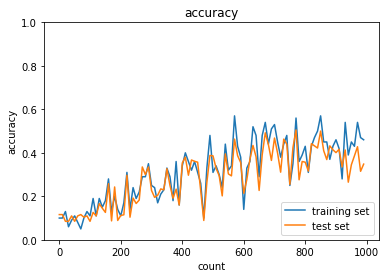

In [43]:

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

# 終わり

In [44]:
#終了時刻
finish_time = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
print("finish_time=",finish_time)
print("total_time=",finish_time-start_time)


finish_time= 2021-04-29 21:56:34.396507+09:00
total_time= 0:06:22.446535
